Notebook prepared by Mathieu Blondel (lecture 1) and Pierre Ablin (lecture 2).

# Lecture 1

## Ridge regression

In [1]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

# Load the Boston housing dataset.
X_boston, y_boston = load_boston(return_X_y=True)

# Split into 60% training, 20% validation and 20% test.
X_boston_tr, X_rest, y_boston_tr, y_rest = \
  train_test_split(X_boston, y_boston, test_size=0.4, random_state=0)
X_boston_val, X_boston_te, y_boston_val, y_boston_te = \
  train_test_split(X_rest, y_rest, test_size=0.5, random_state=0)

**Exercise 1.** Implement the analytical solution of ridge regression $(X^\top X + \alpha I) w = X^\top y$ (see [slides](https://data-psl.github.io/lectures2020/slides/05_optimization_linear_models)) using [scipy.linalg.solve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html). Compute the solution on the training data. Make sure that the gradient at the solution is zero (up to machine precision).

In [2]:
from scipy.linalg import solve

def ridge_regression_solution(X, y, alpha):
  n_samples, n_features = X.shape
  XX = np.dot(X.T, X)
  Xy = np.dot(X.T, y)
  I = np.eye(n_features)
  w_star = solve(XX + alpha * I, Xy)
  return w_star

def ridge_regression_gradient(w, X, y, alpha):
  XX = np.dot(X.T, X)
  Xy = np.dot(X.T, y)
  return np.dot(XX, w) - Xy + alpha * w

w_star = ridge_regression_solution(X_boston_tr, y_boston_tr, alpha=0.1)

gradient = ridge_regression_gradient(w_star, X_boston_tr, y_boston_tr, alpha=0.1)
np.sqrt(np.sum(gradient ** 2))

1.5704672211782347e-09

**Exercise 2.** Train the models for several possible values of alpha (see below). Plot the mean squared error on the test set as a function of alpha. Use the validation data to find the best alpha and display it on the graph using a circle.

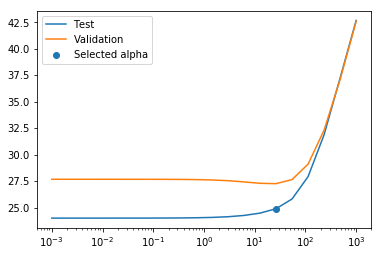

In [3]:
alphas = np.logspace(-3, 3, 20)

validation_values = []
test_values = []

for alpha in alphas:
  w_star = ridge_regression_solution(X_boston_tr, y_boston_tr, alpha)
  
  y_pred_val = np.dot(X_boston_val, w_star)
  y_pred_te = np.dot(X_boston_te, w_star)

  mse_val = np.mean((y_boston_val - y_pred_val) ** 2)
  mse_te = np.mean((y_boston_te - y_pred_te) ** 2)

  validation_values.append(mse_val)
  test_values.append(mse_te)

best_alpha_index = np.argmin(validation_values)
best_alpha = alphas[best_alpha_index]
best_value = test_values[best_alpha_index]

import matplotlib.pyplot as plt
plt.figure()
plt.plot(alphas, test_values, label="Test")
plt.plot(alphas, validation_values, label="Validation")
plt.scatter([best_alpha], [best_value], label="Selected alpha")
plt.xscale("log")
plt.legend(loc="best")
plt.show()

**Bonus exercise.** Implement a scikit-learn compatible estimator class (with fit and predict methods). Compare that you obtain the same results as `sklearn.linear_model.Ridge(fit_intercept=False)`.

In [4]:
from sklearn.base import BaseEstimator, RegressorMixin

class MyRidge(BaseEstimator, RegressorMixin):
  def __init__(self, alpha=1.0):
    self.alpha = alpha

  def fit(self, X, y):
    self.w_ = ridge_regression_solution(X, y, alpha=self.alpha)
    return self

  def predict(self, X):
    return np.dot(X, self.w_)

from sklearn.linear_model import Ridge

print(MyRidge().fit(X_boston_tr, y_boston_tr).predict(X_boston_te)[:10])
print(Ridge(fit_intercept=False).fit(X_boston_tr, y_boston_tr).predict(X_boston_te)[:10])

[29.02919442 24.23132079 22.01189693 23.33453274 27.38233833 18.17573078
 19.96559054 22.42317482 18.90765316 27.76476332]
[29.02919442 24.23132079 22.01189693 23.33453274 27.38233833 18.17573078
 19.96559054 22.42317482 18.90765316 27.76476332]


## Logistic regression

In [5]:
from sklearn.datasets import load_iris

X_iris, y_iris = load_iris(return_X_y=True)
# Keep only two classes for this exercise.
X_iris = X_iris[y_iris <= 1]
y_iris = y_iris[y_iris <= 1]

**Exercise 1.** Make a function that computes 
$$
\text{softplus}(u) = \log(1 + e^u)
$$
and notice that its derivative is
$$
(\text{softplus}(u))' = \frac{e^u}{1 + e^u} = \frac{1}{1 + e^{-u}} = \text{sigmoid}(u).
$$
Using the finite difference formula $f'(u) \approx \frac{f(u + \epsilon) - f(u)}{\epsilon}$ where epsilon is small value (e.g. 10^-6), check that the derivative of softplus is indeed the sigmoid.

In [6]:
import numpy as np
from scipy.special import expit as sigmoid

def finite_difference(function, u, *args, eps=1e-6):
  return (function(u + eps, *args) - function(u, *args)) / (eps)

def softplus(u):
  return np.log(1 + np.exp(u))

print(softplus(3))
print(finite_difference(softplus, 3))
print(sigmoid(3))

3.048587351573742
0.9525741493376927
0.9525741268224334


**Exercise 2.** 
Make a function that computes the likelihood
$$
\text{likelihood}(u_i, y_i) = y_i \log \text{sigmoid}(u_i) + (1-y_i) \log (1-\text{sigmoid}(u_i))
$$
where $u_i = \mathbf{w}^\top \mathbf{x}_i$.
Using
$$
\log \text{sigmoid}(u) = -\text{softplus}(-u)
$$
and
$$
\log(1 - \text{sigmoid}(u)) = -\text{softplus}(u)
$$
make a function that computes the derivative of $\text{likelihood}(u_i, y_i)$ with respect to $u_i$. Check the result by finite difference. Be careful of signs!

In [7]:
def likelihood(u_i, y_i):
  return y_i * np.log(sigmoid(u_i)) + (1 - y_i) * np.log(1 - sigmoid(u_i))

def likelihood_derivative(u_i, y_i):
  return y_i * sigmoid(-u_i) + (1 - y_i) * -sigmoid(u_i)

print(likelihood_derivative(3, 1))
print(finite_difference(likelihood, 3, 1))

0.04742587317756678
0.04742585039269054


**Exercise 3.** Write a function that implements the penalized objective function
$$
L(\mathbf{w})
= -\sum_{i=1}^n y_i \log \text{sigmoid}(\mathbf{w}^\top \mathbf{x}_i) + (1-y_i) \log (1-\text{sigmoid}(\mathbf{w}^\top \mathbf{x}_i)) + \frac{\alpha}{2} \|\mathbf{w}\|^2
$$
and another function that computes its gradient. Reuse `likelihood(u_i, y_i)` and `likelihood_derivative(u_i, y_i)` (you can use a for loop). Check that the gradient is correct using finite differences.

In [20]:
def objective_value(w, X, y, alpha):
  n_samples = len(X)
  value = 0
  for i in range(n_samples):
    value -= likelihood(np.dot(X[i], w), y[i])
  value += 0.5 * alpha * np.sum(w ** 2)
  return value

def objective_gradient(w, X, y, alpha):
  n_samples = len(X)
  gradient = np.zeros_like(w)
  for i in range(n_samples):
    gradient -= likelihood_derivative(np.dot(X[i], w), y[i]) * X[i]
  gradient += alpha * w
  return gradient

def finite_difference_gradient(func, w, *args, eps=1e-6):
  gradient = np.zeros_like(w)
  for j in range(len(w)):
    e_j = np.zeros(len(w))
    e_j[j] = 1
    gradient[j] = (func(w + eps * e_j, *args) - func(w, *args)) / eps
  return gradient

n_samples, n_features = X_iris.shape
w = np.random.randn(n_features)
alpha = 0.1
print(objective_gradient(w, X_iris, y_iris, alpha))
print(finite_difference_gradient(objective_value, w, X_iris, y_iris, alpha))

[-142.88202689  -37.26651948 -158.66001315  -54.93459954]
[-142.88181001  -37.26643249 -158.65996826  -54.93459597]


**Exercise 4.** Implement gradient descent. Check that the objective value is decreasing. Plot the objective value as a function of the number of iterations.

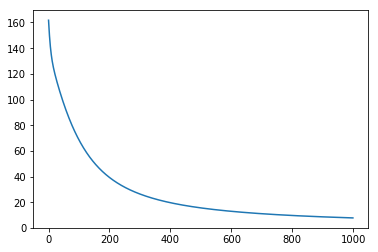

In [21]:
def gradient_descent(value_function, gradient_function, w_init, *args, 
                     step_size=1e-4, num_iterations=1000):
  
  values = []
  w = w_init
  for i in range(num_iterations):
    w = w - step_size * gradient_function(w, *args)
    values.append(value_function(w, *args))
  return values

n_samples, n_features = X_iris.shape
w_init = np.random.randn(n_features)
values = gradient_descent(objective_value, objective_gradient, w, X_iris, y_iris, alpha)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(len(values)), values)
plt.show()

**Exercise 5.** Rewrite `objective_value` and `objective_gradient` without for loop. Check the correctness of your implementation against the version with a for loop.

In [10]:
def objective_value_no_loop(w, X, y, alpha):
  y_pred = np.dot(X, w)
  likelihoods = y * np.log(sigmoid(y_pred)) + (1 - y) * np.log(1 - sigmoid(y_pred))
  value = -likelihoods.sum() 
  value += 0.5 * alpha * np.sum(w ** 2)
  return value

def objective_gradient_no_loop(w, X, y, alpha):
  y_pred = np.dot(X, w)
  likelihood_deriv = y * sigmoid(-y_pred) + (1 - y) * -sigmoid(y_pred)
  gradient = -np.dot(X.T, likelihood_deriv)
  gradient += alpha * w
  return gradient

n_samples, n_features = X_iris.shape
w = np.random.randn(n_features)
alpha = 0.1
print(objective_value(w, X_iris, y_iris, alpha))
print(objective_value_no_loop(w, X_iris, y_iris, alpha))
print(objective_gradient(w, X_iris, y_iris, alpha))
print(objective_gradient_no_loop(w, X_iris, y_iris, alpha))

227.17353142760155
227.1735314276014
[ 15.44465851  60.88469386 -89.58442042 -37.48309804]
[ 15.44465851  60.88469386 -89.58442042 -37.48309804]


Time the two implementations.

In [11]:
%time objective_value(w, X_iris, y_iris, alpha)

CPU times: user 2.24 ms, sys: 108 µs, total: 2.35 ms
Wall time: 1.75 ms


227.17353142760155

In [12]:
%time objective_value_no_loop(w, X_iris, y_iris, alpha)

CPU times: user 256 µs, sys: 12 µs, total: 268 µs
Wall time: 230 µs


227.1735314276014

# Lecture 2

# Stochastic gradient descent

We will focus on the Boston dataset and ridge regression. We will start by scaling the dataset

In [13]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X_boston)
y = y_boston - y_boston.mean()
y /= np.std(y_boston)

**Exercise 6.** Write a function that computes the stochastic gradient of Ridge regression. Check that the mean of the stochastic gradients gives the gradient.

In [14]:
def ridge_objective(w, X, y, alpha):
    residual = y - np.dot(X, w)
    n_samples, n_features = X.shape
    return np.sum(residual ** 2) / n_samples + alpha * np.dot(w, w) / 2


def ridge_gradient(w, X, y, alpha):
    n_samples, n_features = X.shape
    return 2 * (np.dot(X, w) - y).dot(X) / n_samples + alpha * w


def stochastic_gradient(w, i, X, y, alpha):
  n_samples = len(X)
  gradient = np.zeros_like(w)
  gradient = 2 * (np.dot(X[i], w) - y[i]) * X[i]
  gradient += alpha * w
  return gradient


n_samples, n_features = X_boston.shape
w = np.random.randn(n_features)
alpha = 0.1
print(np.mean([stochastic_gradient(w, i, X, y, alpha) for i in range(n_samples)], axis=0))
print(ridge_gradient(w, X, y, alpha))

[ 0.58890263 -1.3431632   1.02958269 -1.09440625  2.18600178 -5.03962171
  1.14297979 -1.71896595 -1.35106566 -0.7850983  -2.8444402   1.02387385
  3.74368222]
[ 0.58890263 -1.3431632   1.02958269 -1.09440625  2.18600178 -5.03962171
  1.14297979 -1.71896595 -1.35106566 -0.7850983  -2.8444402   1.02387385
  3.74368222]


**Exercise 7.** Write a function that implements stochastic gradient descent. Implement two rules for sampling the index: cyclic, and at random. Compare the convergence of both algorithms. What is the role of the step size?

You should especially look at the convergence speed and the value at which the algorithm plateaus.

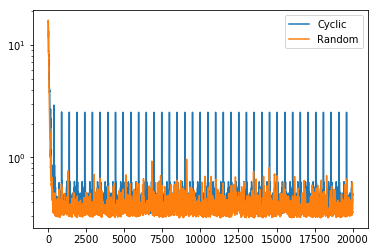

0.28753979757345216
0.29000237503216564
0.3597622588699763


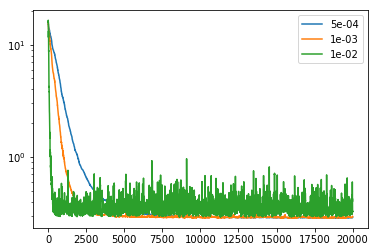

In [15]:
def stochastic_gradient_descent(value_function, gradient_function, w_init, idx_list, *args,
                                step_size=1e-4, num_iterations=1000):
  
  values = []
  w = w_init
  for i in range(num_iterations):
    idx = idx_list[i]
    w = w - step_size * gradient_function(w, idx, *args)
    values.append(value_function(w, *args))
  return values


w_init = np.random.randn(n_features)
num_iterations = 20000
step_size = 1e-2
idx_cyclic = np.arange(num_iterations) % n_samples
values_cyclic = stochastic_gradient_descent(ridge_objective,
                                            stochastic_gradient,
                                            w, idx_cyclic, X,
                                            y, alpha, step_size=step_size,
                                            num_iterations=num_iterations)
idx_random = np.random.randint(0, n_samples, num_iterations)
values_random = stochastic_gradient_descent(ridge_objective,
                                            stochastic_gradient,
                                            w, idx_random, X,
                                            y, alpha, step_size=step_size,
                                            num_iterations=num_iterations)
plt.figure()
plt.plot(np.arange(len(values_cyclic)), values_cyclic, label='Cyclic')
plt.plot(np.arange(len(values_random)), values_random, label='Random')
plt.legend()
plt.yscale('log')
plt.show()

plt.figure()

for step_size in [5e-4, 1e-3, 1e-2]:
    values = stochastic_gradient_descent(ridge_objective,
                                         stochastic_gradient,
                                         w, idx_random, X,
                                         y, alpha, step_size=step_size,
                                         num_iterations=num_iterations)
    plt.plot(values, label='%.e' % step_size)
    print(np.mean(values[-100:]))
plt.legend()
plt.yscale('log')
plt.show()
    


# L-BFGS

L-BFGS is the go-to second order method. It is already implemented in `scipy`:

In [17]:
from scipy.optimize import fmin_l_bfgs_b

**Exercise 8.** Use the L-BFGS code to optimize the logistic regression on the Iris dataset. Compare it with your gradient descent.

Hint: in order to store the function values, you can use the callback function in `fmin_l_bfgs_b`. Don't forget to read the documentation !

In [ ]:
class callback(object):
    def __init__(self):
        self.values = []
    
    def __call__(self, w):
        self.values.append(objective_value_no_loop(w, X_iris, y_iris, alpha))
    

n_samples, n_features = X_iris.shape
w_init = np.random.randn(n_features)
values = gradient_descent(objective_value, objective_gradient, w_init, X_iris, y_iris, alpha)

cb = callback()
_ = fmin_l_bfgs_b(objective_value, w_init, objective_gradient, args=(X_iris, y_iris, alpha), callback=cb)
plt.figure()
plt.plot(np.arange(len(values)), values)
plt.show()
